<a href="https://colab.research.google.com/github/kaveku/NLP/blob/main/Bert_disaster_tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
import nltk
nltk.download('stopwords')
plt.style.use('ggplot')
stop=set(stopwords.words('english'))
import re
from nltk.tokenize import word_tokenize
import gensim
import string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
# from keras.optimizers import Adam
import os 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import warnings
warnings.filterwarnings(action  = 'ignore')

%config Completer.use_jedi = False

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/Disaster_Tweets/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Disaster_Tweets/test.csv')
df_sample = pd.read_csv('/content/drive/MyDrive/Disaster_Tweets/sample_submission.csv')

In [ ]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
df_train.shape

(7613, 5)

In [ ]:
df_test.shape

(3263, 4)

In [ ]:
df_sample.shape

(3263, 2)

# EDA

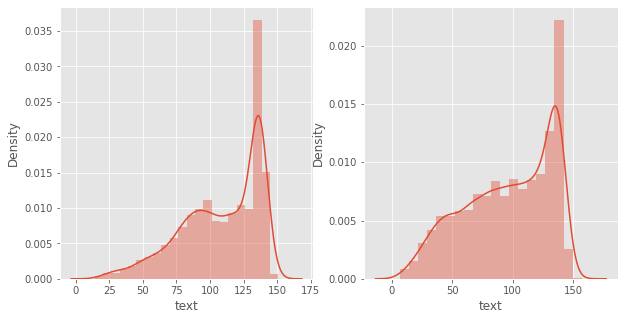

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
len_tweets = df_train[df_train['target']==1]['text'].str.len()
sns.distplot(len_tweets, ax = ax1)
n_len_tweets = df_train[df_train['target']==0]['text'].str.len()
sns.distplot(n_len_tweets, ax = ax2)

# Data Cleaning

In [ ]:
target = df_train.target

cdata = pd.concat([df_train, df_test])

In [ ]:
df_train.shape

(7613, 5)

In [ ]:
!pip install emoji
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 197 kB 8.7 MB/s 
  Created wheel for emoji: filename=emoji-2.0.0-py3-none-any.whl size=193022 sha256=a069cca2cef7de990c836331e857f990c70c61d722fc35c32ffde2a99ec6db91
  Stored in directory: /root/.cache/pip/wheels/ec/29/4d/3cfe7452ac7d8d83b1930f8a6205c3c9649b24e80f9029fc38
Successfully built emoji
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 8.5 MB/s 
     |████████████████████████████████| 596 kB 42.9 MB/s 
     |████████████████████████████████| 101 kB 12.1 MB/s 
     |████████████████████████████████| 6.6 MB 29.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import emoji

def text_preproccessing(df):  
    
    df = df.copy()
    
    def remove_URL(text):
        url = re.compile(r'https?://\S+|www\.\S+')
        return url.sub(r'',text)

    def remove_html(text):
        html=re.compile(r'<.*?>')
        return html.sub(r'',text)

    def remove_punct(text):
        table=str.maketrans('','',string.punctuation)
        return text.translate(table)

    # Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
    def remove_emoji(text):
        emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', text)

    df['text']=df['text'].apply(lambda x : remove_URL(x))
    df['text']=df['text'].apply(lambda x : remove_html(x))
    df['text']=df['text'].apply(lambda x : remove_punct(x))
    # cdata['text']=cdata['text'].apply(lambda x : remove_emoji(x))()


    df['text'] = df['text'].apply(lambda x : emoji.demojize(x))
    
    return df

cdata = text_preproccessing(cdata)

In [ ]:
from transformers import AutoTokenizer, TFBertModel
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
bert = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
max_length = max([len(sent.split()) for sent in cdata.text ])
print(max_length)

31


In [ ]:
df_train = cdata.iloc[:7613,:]
df_text = cdata.iloc[7613:,:]

In [ ]:
x_train = tokenizer(
text = df_train.text.tolist(),
    add_special_tokens = True,
    max_length = 34,
    truncation = True,
    padding = True,
    return_tensors = 'tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True
    
)

target = df_train.target.values

# Model

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy,BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy,BinaryAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model

In [ ]:
max_len = 34
import tensorflow as tf 
from tensorflow.keras.layers import Input, Dense 

input_ids = Input(shape = (max_len,), dtype = tf.int32, name = 'input_ids')
input_mask = Input(shape = (max_len,), dtype = tf.int32, name = 'input_mask')

embeddings = bert([input_ids, input_mask])[1]

out = tf.keras.layers.Dropout(0.1)(embeddings)

out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32,activation = 'relu')(out)

y = Dense(1,activation = 'sigmoid')(out)
    
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True

In [ ]:
optimizer = Adam(
    learning_rate=6e-06, # this learning rate is for bert model , taken from huggingface website 
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

# Set loss and metrics
loss = BinaryCrossentropy(from_logits = True)
metric = BinaryAccuracy('accuracy'),
# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metric)

In [ ]:
train_history = model.fit(
    x ={'input_ids':x_train['input_ids'],'input_mask':x_train['attention_mask']} ,
    y = df_train.target,
#     validation_split = 0.1,
  epochs=6,batch_size=10)

In [ ]:
x_test = tokenizer(
    text=df_test.text.tolist(),
    add_special_tokens=True,
    max_length=34,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [ ]:
x_test['attention_mask']

In [ ]:
predicted = model.predict({'input_ids':x_test['input_ids'],'input_mask':x_test['attention_mask']})

In [ ]:
y_predicted = np.where(predicted>0.5,1,0)
y_predicted = y_predicted.reshape((1,3263))[0]
df_sample['id'] = df_test.id
df_sample['target'] = y_predicted
df_sample.to_csv('submission_bert.csv',index = False)